# Image Segmentation on BraTS 2D lesion-centered MRI scans

This notebook shows how to perform brain tumor segmentations from T1 MRI scans.
The dataset comprises T1, T2, T1ce and FLAIR images.

There are 1251 subjects, every subject has 4 modalities, for every modality there are 3 2D sections crossing the lesion baricentre.
For every subject and section, there is also a lesion mask serving as ground truth.

The objective of this notebook can be expanded towards using multiple views and/or multiple modalities together, and/or testing which modalities are better for segmenting tumor lesions.

This notebook employs the torch and MONAI frameworks, and the UNet architecture.

%%%%%%%%
analisi del notebook di partenza (fa parte della valutazione)
capire se c'è un piano favorevole rispetto agli altri
capire se tutte le modalità sono utili o alcune peggiorano le performance
cambiare parametri ad cazzum


## Imports

In [29]:
!pip install nilearn
!pip install monai
!pip install optuna

In [49]:
import os
import numpy as np
import pandas as pd
import math
import pickle
import time
import matplotlib.pyplot as plt
import nilearn as nil
from nilearn.datasets import load_mni152_template
from nilearn import plotting
import nibabel as nib
import torch
from torch import nn
import torchvision
import monai
from monai.data import DataLoader, Dataset, CacheDataset, SmartCacheDataset
from monai.config import print_config
from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    CopyItemsd,
    SpatialPadd,
    EnsureChannelFirstd,
    Spacingd,
    OneOf,
    SomeOf,
    ScaleIntensityRanged,
    RandSpatialCropSamplesd,
    RandCoarseDropoutd,
    RandCoarseShuffled,
    RandSpatialCropd,
    RandAdjustContrastd,
    ResizeWithPadOrCropd,
    Resized,
    RandRotated,
    NormalizeIntensityd,
    ScaleIntensityRangePercentilesd,
    ScaleIntensityRangePercentiles,
    RandGaussianSmoothd,
    RandGaussianNoised,
    RandFlipd,
    RandCoarseDropoutd,
    RandKSpaceSpikeNoised,
    RandHistogramShiftd,
    RandGaussianSharpend,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    ResizeWithPadOrCropd,
    GaussianSmoothd,
    ConvertToMultiChannelBasedOnBratsClassesd,
    ConcatItemsd,
)
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # if using GPU

## Data Paths

In [31]:
# # mount Google Drive Folder
# from google.colab import drive
# drive.mount('/content/drive')


In [32]:
# %cd "/Users/pietro/Documents/UNI/MAGISTRALE/DeepLearning/Project12"
# REPO_PATH = os.getcwd()
# BRATS_PATH = REPO_PATH + "/BRATS_2D/"
# print(BRATS_PATH)


In [33]:
# from zipfile import ZipFile

# with ZipFile("BRATS_2D.zip", "r") as f:
#     f.extractall("/content/")

In [34]:
!ls /content

ls: /content: No such file or directory


In [35]:
BRATS_PATH = "/Users/pietro/Documents/UNI/MAGISTRALE/DeepLearning/Project12/BRATS_2D/"

In [36]:
total_file_list = os.listdir(BRATS_PATH)
len(total_file_list)

18765

The filenames in the directory follow a specific convention.\
For inputs, the filename is:\
"SUBJECT{XXXX}_MODALITY{XX}_PLANE{XX}.npy"
\
For labels, the filename is:\
"SUBJECT{XXXX}_MASK_PLANE{XX}.npy"\
The label is valid for all modalities of the same subject and plane!

## Data Inspection

Let's load images from the first subject, subject 0.
We will load each view of each modality separately, and then combined in RGB-A format.

In [37]:
subject_ID = 0
modalities = ["t1", "t2", "t1ce", "flair"]
planes = ["00", "01", "10"]

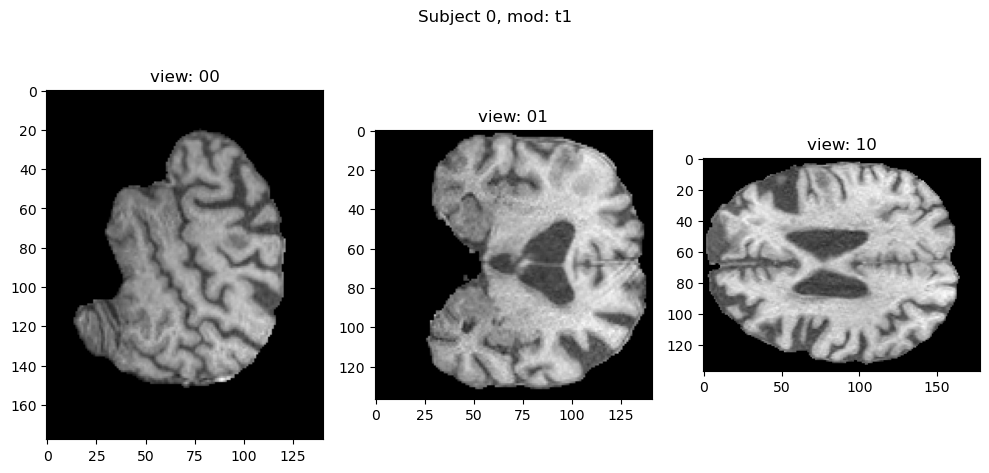

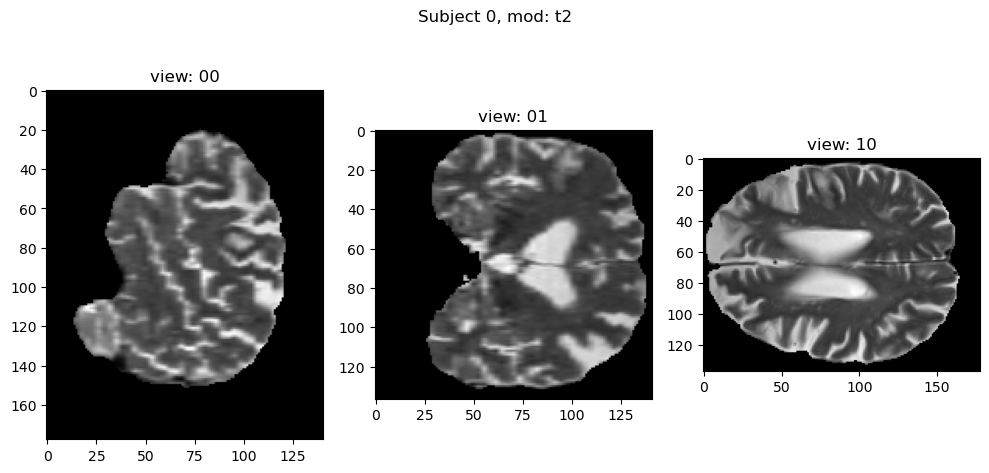

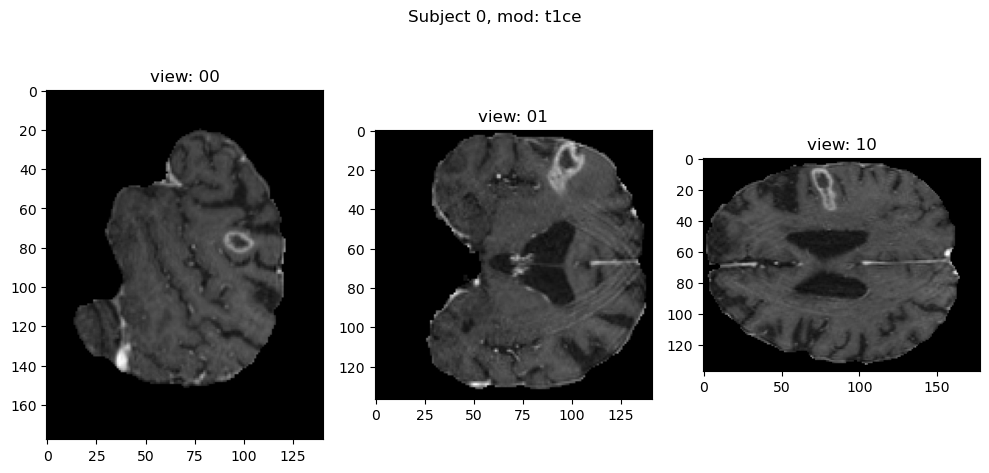

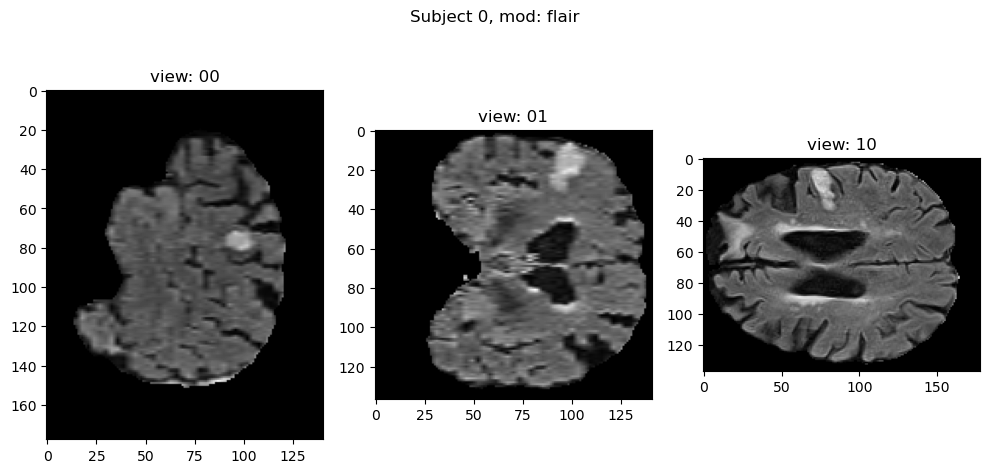

In [38]:
# Only loading the images separately
# iterate over modalities
for modality in modalities:
    plt.figure(figsize=(10,5))
    # iterate over planes
    for i, plane in enumerate(planes):
        filename = f"SUBJECT{subject_ID}_MODALITY{modality}_PLANE{plane}.npy" # format string with {variables}

        # open the file with the correct name in the correct folder
        with open(BRATS_PATH+filename, 'rb') as file:
            image = np.load(file)
        plt.subplot(1,3,i+1)
        plt.imshow(image, cmap="gray")
        plt.title(f"view: {plane}")

    plt.suptitle(f"Subject {subject_ID}, mod: {modality}")
    plt.tight_layout()
    plt.show()
    plt.close()

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

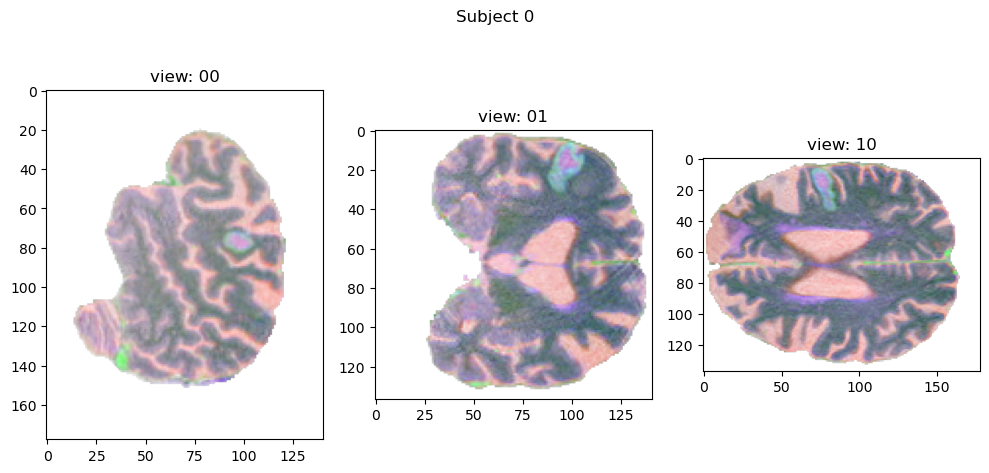

In [39]:
# Loading images and combining them

# create a dictionary containing the modalities
image_dict = {}
for modality in modalities:
    plt.figure(figsize=(10,5))
    # iterate over planes
    # create a dictionary containing the planes
    image_dict[modality] = {}
    for i, plane in enumerate(planes):
        filename = f"SUBJECT{subject_ID}_MODALITY{modality}_PLANE{plane}.npy" # format string with {variables}

        # open the file with the correct name in the correct folder
        with open(BRATS_PATH+filename, 'rb') as file:
            image_dict[modality][plane] = np.load(file)
# now we have all planes for all modalities

plt.figure(figsize=(10,5))
for i, plane in enumerate(planes):
    plt.subplot(1,3,i+1)
    image = np.stack([image_dict["t2"][plane], image_dict["t1ce"][plane], image_dict["flair"][plane], image_dict["t1"][plane]])

    # the image has 4 channels (RGB-A), 1 for each modality, but plt.imshow() wants the channel dimension for last
    image = image.transpose(1,2,0)

    # min-max scaling in the channels, you can try standard scaling
    image = (image - np.min(image, axis=(0,1), keepdims=True)) / (np.max(image, axis=(0,1), keepdims=True) - np.min(image, axis=(0,1), keepdims=True))

    plt.imshow(image, cmap="gray")
    plt.title(f"view: {plane}")

plt.suptitle(f"Subject {subject_ID}")
plt.tight_layout()
plt.show()
plt.close()

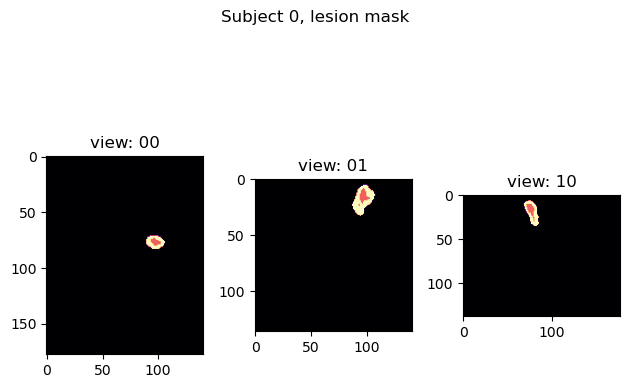

In [40]:
for i, plane in enumerate(planes):
    filename = f"SUBJECT{subject_ID}_MASK_PLANE{plane}.npy" # format string with {variables}

    # open the file with the correct name in the correct folder
    with open(BRATS_PATH+filename, 'rb') as file:
        image = np.load(file)
    plt.subplot(1,3,i+1)

    # the tissue class is 0 or 1, for every channel, channel is the first dimension,
    # we first put the channel dimension last, and then we sum the lesion classes to obtain the tumor region class
    image = image.transpose(1,2,0).sum(axis=-1)
    plt.imshow(image, cmap="magma")
    plt.title(f"view: {plane}")

plt.suptitle(f"Subject {subject_ID}, lesion mask")
plt.tight_layout()
plt.show()
plt.close()

## Training set definition

In [41]:
import random

TRAIN_PATH = BRATS_PATH

######################
# DATASET DEFINITION #
######################

# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Random seed for reproducibility
random_seed = 42
random.seed(random_seed)

# Total subjects
subjects_ID_list = list(range(1251))

# Shuffle subjects
random.shuffle(subjects_ID_list)

# Compute split indices
train_count = int(train_ratio * len(subjects_ID_list))
val_count = int(val_ratio * len(subjects_ID_list))

# Split subjects
train_subjects = subjects_ID_list[:train_count]
val_subjects = subjects_ID_list[train_count:train_count + val_count]
test_subjects = subjects_ID_list[train_count + val_count:]

print(f"Training subjects: {len(train_subjects)}")
print(f"Validation subjects: {len(val_subjects)}")
print(f"Test subjects: {len(test_subjects)}")

# function to generate data for each split
# Using only the plane 00
def generate_split_data(subjects):
    brains_t1_t = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt1_PLANE{'00'}.npy" for subject in subjects]
    brains_t2_t = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt2_PLANE{'00'}.npy" for subject in subjects]
    brains_t1ce_t = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYt1ce_PLANE{'00'}.npy" for subject in subjects]
    brains_flair_t = [TRAIN_PATH+f"SUBJECT{subject}_MODALITYflair_PLANE{'00'}.npy" for subject in subjects]
    masks_t = [TRAIN_PATH+f"SUBJECT{subject}_MASK_PLANE{'00'}.npy" for subject in subjects]

    return [
        {
            "image_t1": brain_t1,
            "image_t2": brain_t2,
            "image_t1ce": brain_t1ce,
            "image_flair": brain_flair,
            "mask": mask,
        }
        for brain_t1, brain_t2, brain_t1ce, brain_flair, mask in zip(
            brains_t1_t, brains_t2_t, brains_t1ce_t, brains_flair_t, masks_t
        )
    ]

# Generate datasets
train_data = generate_split_data(train_subjects)
val_data = generate_split_data(val_subjects)
test_data = generate_split_data(test_subjects)

print(f"Train Data: {len(train_data)} samples")
print(f"Validation Data: {len(val_data)} samples")
print(f"Test Data: {len(test_data)} samples")

print(train_subjects)
print(train_data)


Training subjects: 875
Validation subjects: 250
Test subjects: 126
Train Data: 875 samples
Validation Data: 250 samples
Test Data: 126 samples
[1001, 1216, 1248, 889, 923, 739, 1226, 382, 855, 614, 107, 32, 1048, 512, 1117, 195, 654, 829, 587, 356, 808, 950, 804, 192, 1135, 526, 261, 647, 35, 622, 868, 772, 461, 1233, 276, 809, 49, 989, 348, 797, 179, 1005, 502, 861, 1045, 66, 1207, 294, 1214, 383, 787, 712, 724, 504, 298, 624, 731, 434, 1060, 463, 1095, 1019, 100, 1097, 428, 751, 599, 1020, 241, 1236, 508, 726, 21, 617, 891, 662, 55, 220, 1006, 783, 721, 768, 1024, 346, 942, 671, 794, 419, 1032, 536, 1072, 289, 263, 1129, 1187, 454, 187, 805, 895, 337, 632, 1237, 529, 202, 18, 210, 732, 562, 67, 515, 56, 332, 1181, 969, 975, 963, 916, 840, 1075, 4, 588, 1107, 557, 728, 361, 259, 792, 1121, 445, 121, 81, 11, 214, 991, 164, 960, 800, 367, 633, 1141, 1036, 462, 246, 709, 1012, 537, 844, 898, 485, 148, 427, 857, 286, 697, 742, 395, 87, 352, 643, 17, 34, 1038, 153, 212, 668, 347, 1014, 998

In [42]:
print(train_data[3]["image_t1"])


/Users/pietro/Documents/UNI/MAGISTRALE/DeepLearning/Project12/BRATS_2D/SUBJECT889_MODALITYt1_PLANE00.npy


In [43]:
modality_keys = ["image_t1", "image_t2", "image_t1ce", "image_flair"]
from monai.transforms import RandZoomd
from monai.transforms import Rand2DElasticd


# Try to add more modalities
train_transforms = Compose([
        LoadImaged(keys = modality_keys +  ["mask"]),
        EnsureChannelFirstd(keys=modality_keys),
        CropForegroundd(keys=modality_keys +  ["mask"], source_key="image_t1"),
        ConcatItemsd(keys=modality_keys, name="image"),
        Spacingd(keys=["image", "mask"], pixdim=(1,1,1), mode=("trilinear", "trilinear")), #Try trilinear and nearest
        SpatialPadd(keys=["image", "mask"], spatial_size=(256,256), method="symmetric", mode="constant"),
        # you can add data augmentations here, see Imports of monai.transforms

    ## ADD MORE TRANSFORMS & AUGMENTATIONS HERE

    # Elastic deformation
    Rand2DElasticd(
        keys=["image", "mask"],
        spacing=(10, 10),          # Grid spacing for deformation
        magnitude_range=(1, 2),   # Range of deformation magnitudes
        prob=0.3,                 # Probability of applying deformation
        rotate_range=(0.1, 0.1),  # Random rotation (in radians)
        shear_range=(0.1, 0.1),   # Random shearing
        mode=("bilinear", "nearest"),  # Interpolation mode for image/mask
    ),

    RandFlipd(
        keys=["image", "mask"],
        spatial_axis=[0],  # Flip along x-axis
        prob=0.5,
    ),
    RandGaussianNoised(
        keys=["image"],
        mean=0.0,
        std=0.1,
        prob=0.2,),

    RandAdjustContrastd( # Random brightness adjustment
    keys=["image"],
    prob=0.3,
    gamma=(0.7, 1.5),
    ),

    RandZoomd( # Random zoom
    keys=["image", "mask"],
    min_zoom=0.9,
    max_zoom=1.1,
    prob=0.3,
    mode=("trilinear", "nearest"),
    ),

    # RandSpatialCropd(
    #     keys=["image", "mask"],
    #     roi_size=(96, 96),  # Smaller cropped size
    #     random_size=False,
    # ),

    # Add other transforms here
])


val_transforms = Compose([
        LoadImaged(keys = modality_keys +  ["mask"]),
        EnsureChannelFirstd(keys=modality_keys),
        CropForegroundd(keys=modality_keys +  ["mask"], source_key="image_t1"),
        ConcatItemsd(keys=modality_keys, name="image"),
        Spacingd(keys=["image", "mask"], pixdim=(1,1,1), mode=("trilinear", "trilinear")), #Try trilinear and nearest
        SpatialPadd(keys=["image", "mask"], spatial_size=(256,256), method="symmetric", mode="constant"),
        # you can add data augmentations here, see Imports of monai.transforms
])

/Users/pietro/miniconda3/envs/progettoDeep/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [44]:
check_ds = Dataset(data=train_data, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, num_workers=1)

from monai.utils import first
check_data = next(iter(check_loader))
image = check_data["image"]
label = check_data["mask"]
print(f"image shape: {image.shape}")
print(f"mask shape: {label.shape}")

# Validation DataLoader
val_ds = Dataset(data=val_data, transform=val_transforms)
val_loader = DataLoader(val_ds,batch_size=1, num_workers=1)




image shape: torch.Size([1, 4, 256, 256])
mask shape: torch.Size([1, 3, 256, 256])


Data are loaded with shape (B, C, H, W), B: batch size; C: channels; H: height; W: width

## Data Class and Data Loader

In [45]:
# Define DataLoader using MONAI, CacheDataset needs to be used
# from monai.data.utils import pad_list_data_collate
BATCH_SIZE = 32
if BATCH_SIZE > 1:
        def collate_fn(batch):
            return monai.data.utils.pad_list_data_collate(batch, method="symmetric", mode="replicate")

In [46]:
train_ds = Dataset(data=train_data, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [26]:
# Setting the device

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [50]:
import optuna
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss, GeneralizedDiceLoss, GeneralizedDiceFocalLoss, GeneralizedWassersteinDiceLoss
from monai.metrics import DiceMetric, DiceHelper
###################################################
#           Define the Optuna objective
###################################################
def objective(trial):
    """
    This function is called by Optuna. It samples hyperparameters,
    builds the model and trains it for a fixed number of epochs.
    We return the validation loss (or any other metric) that we want to minimize.
    """

    # 1) Suggest hyperparameters (example: learning rate, dropout)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)

    # 2) Define model
    model = monai.networks.nets.UNet(spatial_dims=2, in_channels=4, out_channels=3, channels=[16,32,64,128,256,512],
                                 strides=[2,2,2,2,2], kernel_size=3, up_kernel_size=3,
                                 act='PRELU', norm='INSTANCE',
                                 dropout=dropout, bias=True).to(device)

    # 3) Define loss function, optimizer, scheduler, etc.
    loss_function = DiceCELoss(lambda_ce=0.5, sigmoid=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           mode="min",
                                                           factor=0.5,
                                                           patience=3,
                                                           verbose=False)

    # 4) Training loop: do fewer epochs to keep it fast
    max_epochs_for_optuna = 10  # fewer epochs than final training
    epoch_loss = 0
    steps = 0
    val_loss = 0
    val_steps = 0

    for epoch in range(max_epochs_for_optuna):
        model.train()


        for batch_data in train_loader:
            steps += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["mask"].to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= steps

        # Validation after each epoch
        model.eval()

        with torch.no_grad():
            for val_data_batch in val_loader:
                val_steps += 1
                val_inputs = val_data_batch["image"].to(device)
                val_labels = val_data_batch["mask"].to(device)

                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_labels).item()

        val_loss /= val_steps
        scheduler.step(val_loss)  # update LR scheduler

        # (Optional) Prune unpromising trials
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss  # we want to minimize val_loss

################################
#     Run the Optuna Study
################################
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)  # number of trials; adjust as needed

print("Number of finished trials:", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Loss:", best_trial.value)
print("  Params:", best_trial.params)

# Last time:
# Number of finished trials: 5
# Best trial:
#   Loss: 0.033807761974469046
#   Params: {'lr': 0.009484050312125744, 'dropout': 0.4}



[I 2024-12-23 16:54:51,806] A new study created in memory with name: no-name-2bba99f1-e89c-4fd8-8b28-805aafd3517f
/Users/pietro/miniconda3/envs/progettoDeep/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-12-23 17:00:14,946] Trial 0 finished with value: 0.04120357698858833 and parameters: {'lr': 0.0011316760452724107, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.04120357698858833.
[W 2024-12-23 17:00:28,506] Trial 1 failed with parameters: {'lr': 0.0006171358627317061, 'dropout': 0.5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/pietro/miniconda3/envs/progettoDeep/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/w5/tpptwdhj1g74ggf9ykxjdwhw0000gn/T/ipykernel_19886/142950654.py", line 56, i

KeyboardInterrupt: 

## Model definition

In [51]:
best_trial.params["lr"] = 0.009484050312125744 #To try with older
best_trial.params["dropout"] = 0.4 

best_lr = best_trial.params["lr"]
best_dropout = best_trial.params["dropout"]

print(f"Best learning rate: {best_lr}")
print(f"Best dropout: {best_dropout}")

model = monai.networks.nets.UNet(spatial_dims=2, in_channels=4, out_channels=3, channels=[16,32,64,128,256,512],
                                 strides=[2,2,2,2,2], kernel_size=3, up_kernel_size=3,
                                 act='PRELU', norm='INSTANCE',
                                 dropout=best_dropout, bias=True)

Best learning rate: 0.009484050312125744
Best dropout: 0.4


In [52]:
def count_pms(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [53]:
count_pms(model)

2652301

## Define Training recipe

In [54]:
#LR = 1e-3 # More stable for Adam

max_epochs = 100
loss_function = DiceCELoss(lambda_ce=0.5, sigmoid=True) # BraTS dataset is multiclass, try softmax replacing sigmoid
dice_metric = DiceMetric(include_background=True, reduction="mean") #Setting include_background=True means the Dice score will also consider the background class (non-tumor regions).
optimizer = torch.optim.Adam(model.parameters(), best_lr)
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",  # Minimizing the validation loss
    factor=0.5,  # Multiply LR by 0.5 when triggered
    patience=5,  # Wait 5 epochs with no improvement
    verbose=True  # Print updates when LR is adjusted
)


/Users/pietro/miniconda3/envs/progettoDeep/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Model Training

In [55]:
model.to(device)
print(next(model.parameters()).device)

mps:0


----------
epoch 1/100
epoch 1 average loss: 0.9180
current epoch: 1 train_set mean dice: 0.1647
time consuming of epoch 1 is: 43.7829
inspection of results with random sample from training
epoch 1 average validation loss: 0.8551
Current Learning Rate: 0.009484050312125744


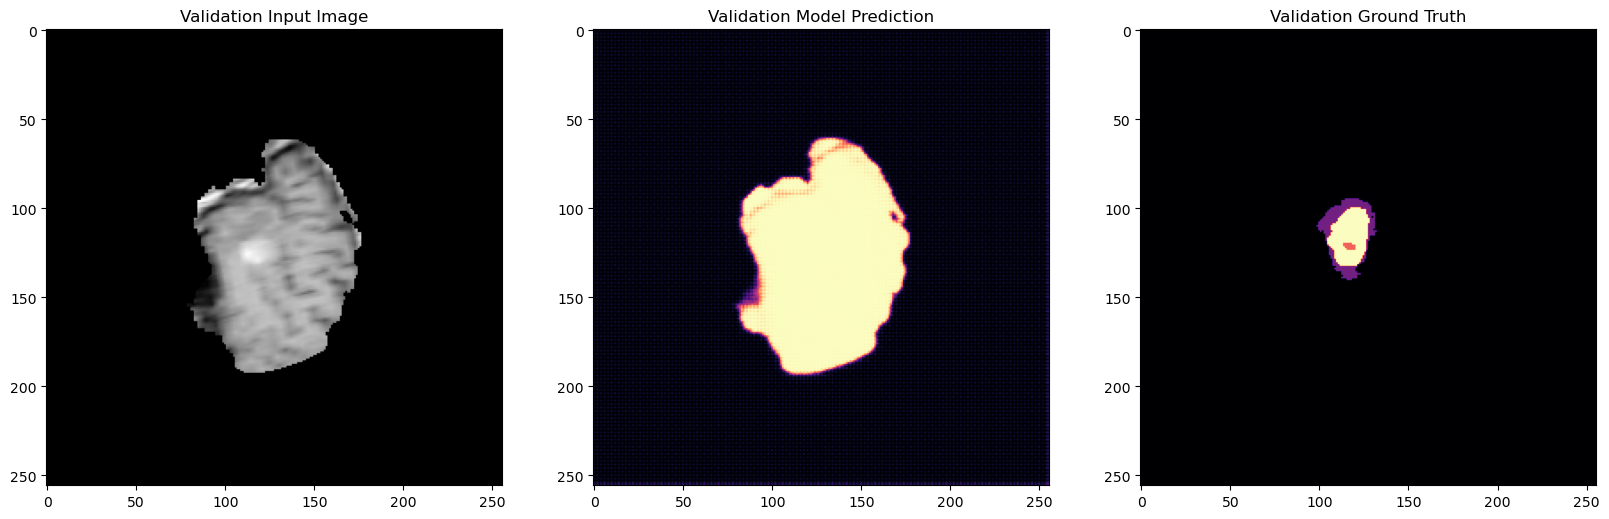

----------
epoch 2/100
epoch 2 average loss: 0.7185
current epoch: 2 train_set mean dice: 0.3690
time consuming of epoch 2 is: 46.7070
inspection of results with random sample from training
epoch 2 average validation loss: 0.4678
Current Learning Rate: 0.009484050312125744


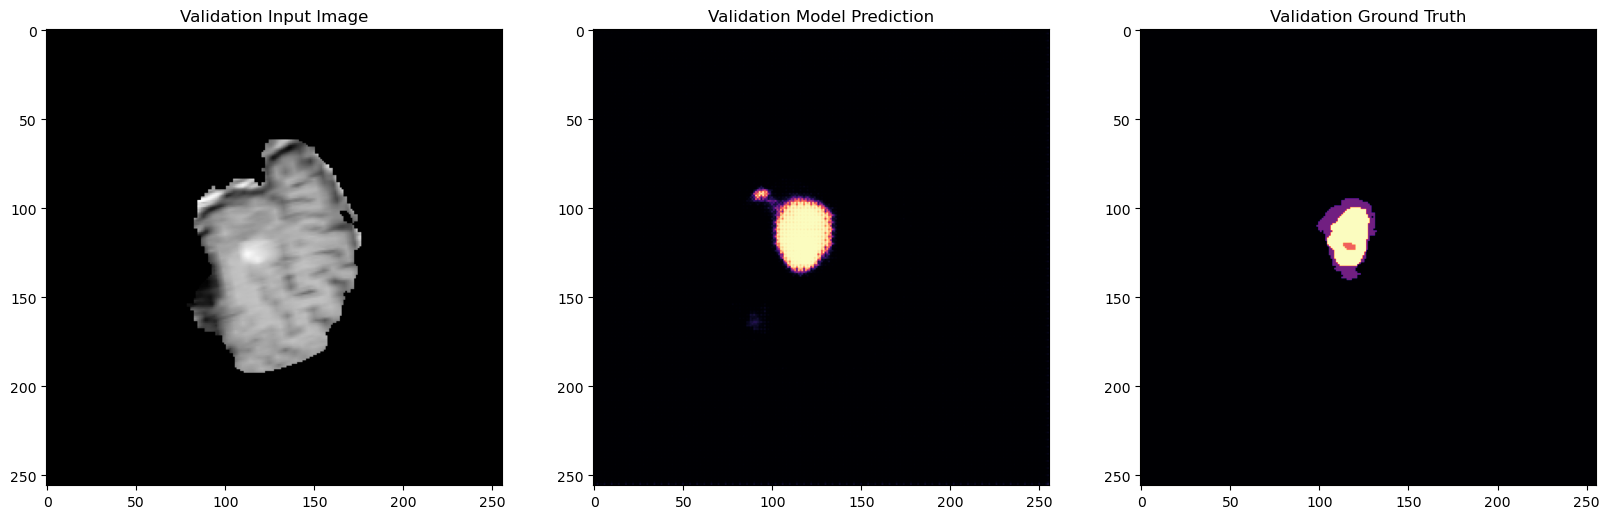

----------
epoch 3/100
epoch 3 average loss: 0.4758
current epoch: 3 train_set mean dice: 0.5943
time consuming of epoch 3 is: 44.6136
inspection of results with random sample from training
epoch 3 average validation loss: 0.4283
Current Learning Rate: 0.009484050312125744


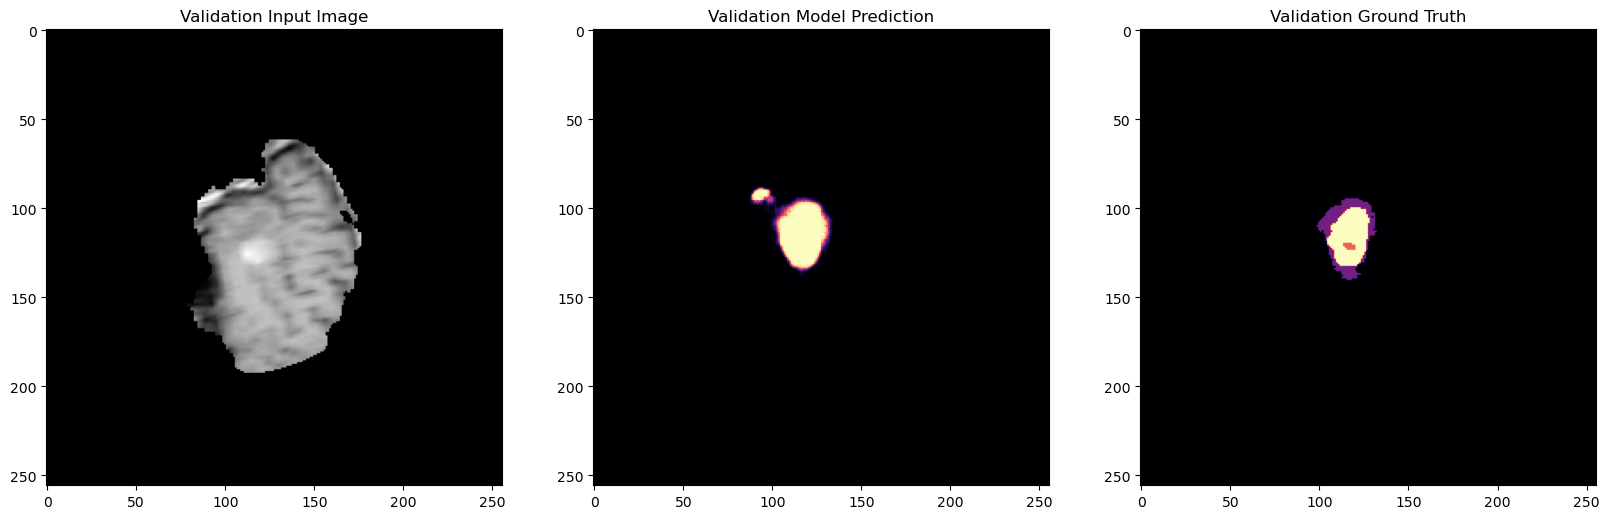

----------
epoch 4/100
epoch 4 average loss: 0.4431
current epoch: 4 train_set mean dice: 0.6262
time consuming of epoch 4 is: 38.7918
inspection of results with random sample from training
epoch 4 average validation loss: 0.3812
Current Learning Rate: 0.009484050312125744


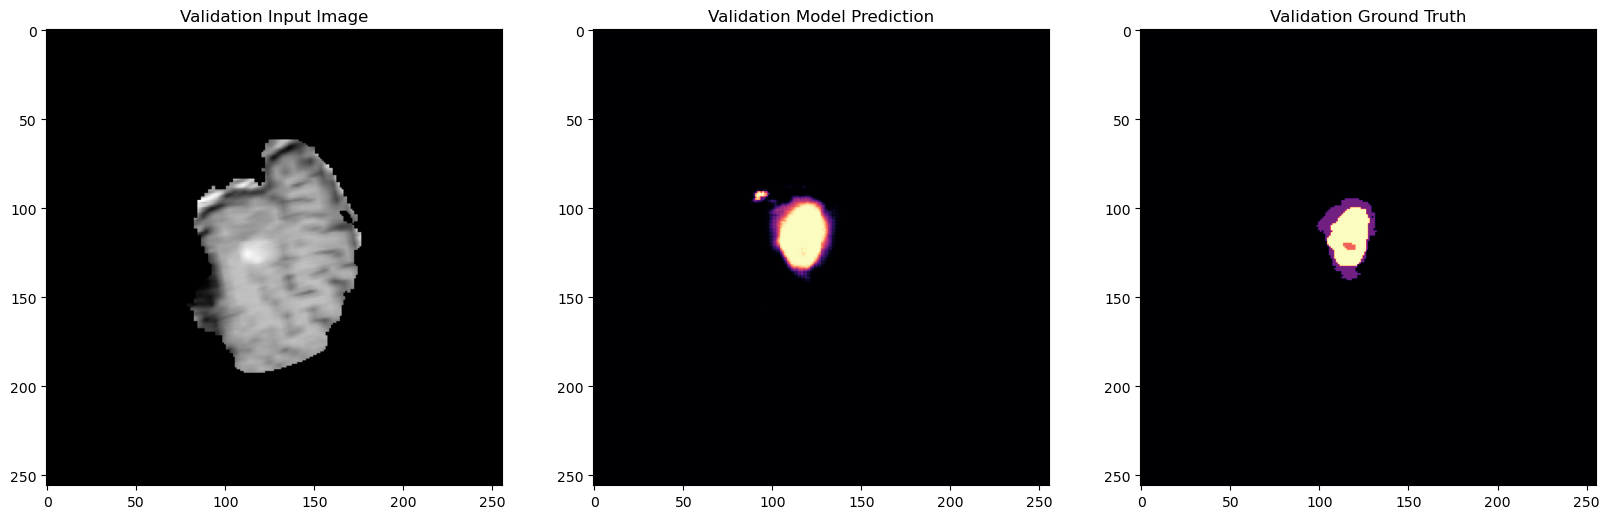

----------
epoch 5/100
epoch 5 average loss: 0.4217
current epoch: 5 train_set mean dice: 0.6595
time consuming of epoch 5 is: 39.7315
inspection of results with random sample from training
epoch 5 average validation loss: 0.3448
Current Learning Rate: 0.009484050312125744


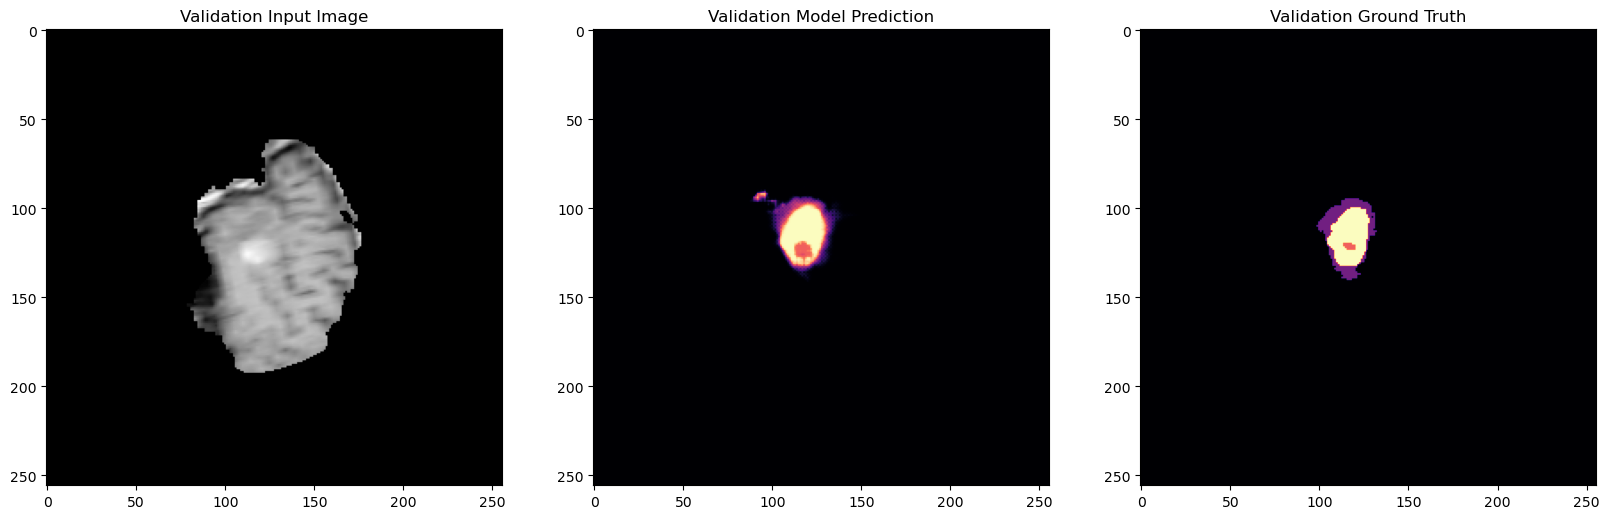

----------
epoch 6/100


In [ ]:
total_start = time.time()

# initialize lists for recording training history
epoch_loss_values = []
epoch_dice_scores = []
epoch_val_loss_values = []
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    epoch_loss = 0
    steps = 0

    # count batch_index and load batch of images and labels
    for batch_idx, batch_data in enumerate(train_loader):
        step_start = time.time()
        steps += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["mask"].to(device),
        )
        # predict
        outputs = model(inputs)
        # compute loss based on predictions
        loss = loss_function(outputs, labels)
        # compute gradients
        loss.backward()
        # apply weight update based on gradients
        optimizer.step()
        # reset optimizer state for next batch update
        optimizer.zero_grad()

        # increase the loss for the current epoch
        epoch_loss += loss.item()

        # compute Dice score for current predictions
        outputs_ = torch.nn.functional.sigmoid(outputs.detach().clone())
        outputs_[outputs_>=0.5] = 1
        outputs_[outputs_<0.5] = 0
        dice_metric(y_pred=outputs_, y=labels)

    # compute average loss of this epoch and add to history
    epoch_loss /= steps
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # compute average Dice of this epoch and add to history
    metric = dice_metric.aggregate().item()
    epoch_dice_scores.append(metric)
    dice_metric.reset()
    print(f"current epoch {epoch + 1}: train_set mean dice: {metric:.4f}")

    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    
    #print("inspection of results with random sample from training")


    # Validation phase
    model.eval()
    val_loss = 0
    val_steps = 0
    with torch.no_grad():
        for val_batch_data in val_loader:
            val_steps += 1
            val_inputs = val_batch_data["image"].to(device)
            val_labels = val_batch_data["mask"].to(device)

            # Forward pass
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels).item()

    # Compute average validation loss for the epoch
    val_loss /= val_steps
    epoch_val_loss_values.append(val_loss)
    print(f"epoch {epoch + 1} average validation loss: {val_loss:.4f}")

    # Scheduler step based on validation loss
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr}")



    # eval mode to test on a training sample, without dropout and without learning from gradients
    #model.eval()
    #with torch.no_grad():
    #    batch = next(iter(train_loader))
    #    inputs, labels = batch["image"].to(device), batch["mask"].to(device)
    #    outputs = model(inputs)
    #brain_img = inputs[0].detach().cpu()
    #mask_img = labels[0].detach().cpu()
    #mask_out = torch.nn.functional.sigmoid(outputs[0].detach().cpu())

    # Get the first sample in the batch
    val_brain_img = val_inputs[0].detach().cpu()
    val_mask_img = val_labels[0].detach().cpu()
    val_mask_out = torch.nn.functional.sigmoid(val_outputs[0].detach().cpu())

    # Plot results
    plt.figure(figsize=(20, 10))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Validation Input Image")
    plt.imshow(val_brain_img[0], cmap="Greys_r")

    # Model prediction
    plt.subplot(1, 3, 2)
    plt.title("Validation Model Prediction")
    val_mask_out = val_mask_out.permute(1, 2, 0).sum(axis=-1)
    plt.imshow(val_mask_out, cmap="magma")

    # Ground truth
    plt.subplot(1, 3, 3)
    plt.title("Validation Ground Truth")
    val_mask_img = val_mask_img.permute(1, 2, 0).sum(axis=-1)
    plt.imshow(val_mask_img, cmap="magma")

    plt.show()
    plt.close()


    model.train()

total_time = time.time() - total_start

## Model History

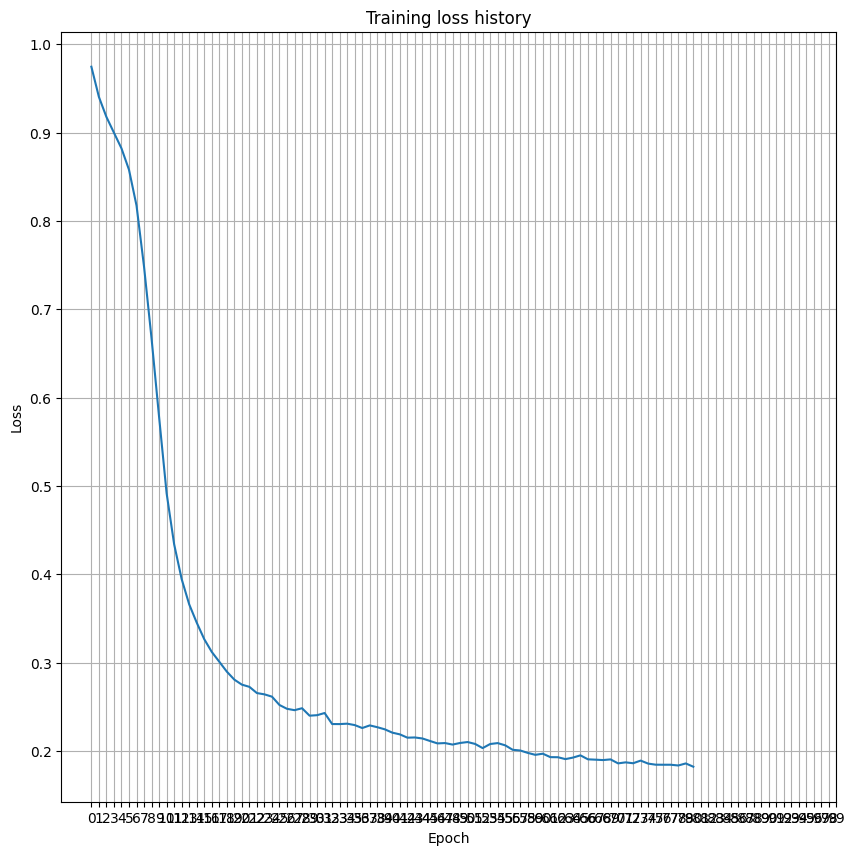

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(epoch_loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([i for i in range(max_epochs)])
plt.title("Training loss history")
plt.grid()
plt.show()
plt.close()

In [11]:
# TEST on the test set the model


test_transforms = Compose([
        LoadImaged(keys = modality_keys +  ["mask"]),
        EnsureChannelFirstd(keys=modality_keys),
        CropForegroundd(keys=modality_keys +  ["mask"], source_key="image_t1"),
        ConcatItemsd(keys=modality_keys, name="image"),
        Spacingd(keys=["image", "mask"], pixdim=(1,1,1), mode=("trilinear", "trilinear")), #Try trilinear and nearest
        SpatialPadd(keys=["image", "mask"], spatial_size=(256,256), method="symmetric", mode="constant"),
])


# Validation DataLoader
test_ds = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(test_ds,batch_size=1, num_workers=1)


# Test Loop
model.eval()  # Set model to evaluation mode
test_metrics = []  # Store metrics for analysis
test_loss = 0
test_steps = 0
with torch.no_grad():
    for test_batch_data in test_loader:
        test_steps += 1
        test_inputs = test_batch_data["image"].to(device)
        test_labels = test_batch_data["mask"].to(device)

        # Forward pass
        test_outputs = model(test_inputs)

        # Post-process outputs if necessary (e.g., applying sigmoid or softmax for probabilities)
        test_outputs = torch.sigmoid(test_outputs)
        test_loss += loss_function(test_outputs, test_labels).item()

# Calculate Average Metrics
test_loss /= test_steps

print(f"epoch {epoch + 1} average validation loss: {test_loss:.4f}")


# Get the first sample in the batch
test_brain_img = test_inputs[0].detach().cpu()
test_mask_img = test_labels[0].detach().cpu()
test_mask_out = torch.nn.functional.sigmoid(test_outputs[0].detach().cpu())

# Plot results
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(1, 3, 1)
plt.title("test Input Image")
plt.imshow(test_brain_img[0], cmap="Greys_r")

# Model prediction
plt.subplot(1, 3, 2)
plt.title("test Model Prediction")
test_mask_out = test_mask_out.permute(1, 2, 0).sum(axis=-1)
plt.imshow(test_mask_out, cmap="magma")

# Ground truth
plt.subplot(1, 3, 3)
plt.title("test Ground Truth")
test_mask_img = test_mask_img.permute(1, 2, 0).sum(axis=-1)
plt.imshow(test_mask_img, cmap="magma")

plt.show()
plt.close()